<a href="https://colab.research.google.com/github/gliwork/Innopolis/blob/main/create_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow.keras.datasets as tfds
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B1
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import h5py

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip '/content/drive/MyDrive/dataset_test.zip' -d '/content/sample_data/'

Archive:  /content/drive/MyDrive/dataset_test.zip
   creating: /content/sample_data/dataset_test/
   creating: /content/sample_data/dataset_test/01/
  inflating: /content/sample_data/dataset_test/01/IMG_20230920_145004 (2).jpg  
  inflating: /content/sample_data/dataset_test/01/IMG_20230920_145004.jpg  
  inflating: /content/sample_data/dataset_test/01/IMG_20230920_145009 (2).jpg  
  inflating: /content/sample_data/dataset_test/01/IMG_20230920_145009.jpg  
  inflating: /content/sample_data/dataset_test/01/IMG_20230920_145010 (2).jpg  
  inflating: /content/sample_data/dataset_test/01/IMG_20230920_145010.jpg  
  inflating: /content/sample_data/dataset_test/01/IMG_20230920_145014 (2).jpg  
  inflating: /content/sample_data/dataset_test/01/IMG_20230920_145014.jpg  
  inflating: /content/sample_data/dataset_test/01/IMG_20230920_145018 (2).jpg  
  inflating: /content/sample_data/dataset_test/01/IMG_20230920_145018.jpg  
  inflating: /content/sample_data/dataset_test/01/IMG_20230920_145019 (

In [6]:
!unzip '/content/drive/MyDrive/dataset.zip' -d '/content/sample_data'

Archive:  /content/drive/MyDrive/dataset.zip
   creating: /content/sample_data/dataset/
   creating: /content/sample_data/dataset/01/
  inflating: /content/sample_data/dataset/01/IMG_20230920_144856 (2).jpg  
  inflating: /content/sample_data/dataset/01/IMG_20230920_144856.jpg  
  inflating: /content/sample_data/dataset/01/IMG_20230920_144857 (2).jpg  
  inflating: /content/sample_data/dataset/01/IMG_20230920_144857.jpg  
  inflating: /content/sample_data/dataset/01/IMG_20230920_144857_1 (2).jpg  
  inflating: /content/sample_data/dataset/01/IMG_20230920_144857_1.jpg  
  inflating: /content/sample_data/dataset/01/IMG_20230920_144858 (2).jpg  
  inflating: /content/sample_data/dataset/01/IMG_20230920_144858.jpg  
  inflating: /content/sample_data/dataset/01/IMG_20230920_144859 (2).jpg  
  inflating: /content/sample_data/dataset/01/IMG_20230920_144859.jpg  
  inflating: /content/sample_data/dataset/01/IMG_20230920_144900 (2).jpg  
  inflating: /content/sample_data/dataset/01/IMG_20230920

In [ ]:
#Start module from here

In [7]:
#this part is only due to cyrillic characters issue in folder names reading on my mashine
detail_names_list = ['CS120.01.413', 'CS120.07.442', 'CS150.01.427-01', 'SU160.00.404', 'SU80.01.426', 'SU80.10.409A', 'ЗВТ86.103К-02',
 'СВМ.37.060', 'СВМ.37.060А', 'СВП-120.00.060', 'СВП120.42.020', 'СВП120.42.030', 'СК20.01.01.01.406',
 'СК20.01.01.02.402', 'СК30.01.01.02.402', 'СК30.01.01.03.403', 'СК50.01.01.404', 'СК50.02.01.411', 'СПО250.14.190']

In [8]:
import os
path = os.getcwd()
data_dir = path + '/sample_data/dataset/'
#os.scandir
#from glob import glob
#glob('C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\*', recursive = True)

In [9]:
data_dir

'/content/sample_data/dataset/'

In [10]:
batch_size = 32
img_height = 300
img_width = 300

train_ds1 = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=100,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  batch_size=batch_size)

Found 1341 files belonging to 19 classes.
Using 1073 files for training.


In [11]:
val_ds1 = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1341 files belonging to 19 classes.
Using 268 files for validation.


In [12]:
test_ds1 = tf.keras.utils.image_dataset_from_directory(
  '/content/sample_data/test/dataset_test',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 199 files belonging to 19 classes.


In [13]:
class_names = train_ds1.class_names
print(class_names)


['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


In [14]:
num_classes = len(class_names)

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds1 = train_ds1.cache().prefetch(buffer_size=AUTOTUNE)
val_ds1 = val_ds1.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    start_from_epoch=10,
    patience=5
)
model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/sample_data/best_model.keras', #_final
    save_best_only = True,
)
callbacks = [early_stop,model_save]

In [17]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.Resizing(img_height, img_width),
    tf.keras.layers.RandomRotation(factor=0.4),
    tf.keras.layers.RandomContrast(factor=0.2),
])


In [18]:
#test

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    start_from_epoch=10,
    patience=5
)
model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/sample_data/{epoch:02d}-{val_loss:.2f}_aug_100.hdf5',
    save_best_only = True,
)
callbacks = [early_stop,model_save]



epochs = 100

# create the base pre-trained model
base_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape = (img_height, img_width, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model_tmp = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (img_height, img_width, 3)),#input_shape=input_shape
    data_augmentation,
    model])

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_tmp.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True
  metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model_tmp.fit(
    train_ds1,
    validation_data=val_ds1,
    epochs=epochs, callbacks=[callbacks])

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
#   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_tmp.layers[:202]:
   layer.trainable = False
for layer in model_tmp.layers[202:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import Adam
model_tmp.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    ema_momentum=0.9),
    #SGD(learning_rate=0.0005, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True
    metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history1 = model_tmp.fit(
    train_ds1,
    validation_data=val_ds1,
    epochs=epochs, callbacks=[callbacks])

28456008/28456008 [==============================] - 2s 0us/step
Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 1.5363 - accuracy: 0.5163

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 90s 2s/step - loss: 1.5363 - accuracy: 0.5163 - val_loss: 0.7300 - val_accuracy: 0.7351
Epoch 2/100
34/34 [==============================] - 6s 189ms/step - loss: 0.6787 - accuracy: 0.7707 - val_loss: 0.4867 - val_accuracy: 0.8507
Epoch 3/100
34/34 [==============================] - 5s 149ms/step - loss: 0.5199 - accuracy: 0.8332 - val_loss: 0.5513 - val_accuracy: 0.8134
Epoch 4/100
34/34 [==============================] - 5s 159ms/step - loss: 0.4336 - accuracy: 0.8462 - val_loss: 0.3577 - val_accuracy: 0.8843
Epoch 5/100
34/34 [==============================] - 6s 165ms/step - loss: 0.3639 - accuracy: 0.8611 - val_loss: 0.3182 - val_accuracy: 0.8881
Epoch 6/100
34/34 [==============================] - 5s 160ms/step - loss: 0.3501 - accuracy: 0.8733 - val_loss: 0.3384 - val_accuracy: 0.8619
Epoch 7/100
34/34 [==============================] - 6s 164ms/step - loss: 0.2974 - accuracy: 0.8900 - val_loss: 0.2227 - val_accuracy: 0.9179
Epoch 8/100
3

In [19]:
def save_model_checkpoint(epoch, logs):
    if logs['val_loss'] < save_model_checkpoint.best_val_loss:
        save_model_checkpoint.best_val_loss = logs['val_loss']
        model.save_weights(path + '/model_checkpoint')
        print('Model checkpoint saved.')

save_model_checkpoint.best_val_loss = float('inf')



In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    start_from_epoch=10,
    patience=5
)
model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/sample_data/best_model.keras', #_final
    save_best_only = True,
)
callbacks = [early_stop,model_save]

In [21]:
epochs = 40

# create the base pre-trained model
base_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape = (img_height, img_width, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True
  metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(
    train_ds1,
    validation_data=val_ds1,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=save_model_checkpoint)])#, callbacks=[callbacks]

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
#   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:198]:
   layer.trainable = False
for layer in model.layers[198:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    ema_momentum=0.95),
    #SGD(learning_rate=0.0001, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True
    metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history1 = model.fit(
    train_ds1,
    validation_data=val_ds1,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=save_model_checkpoint)])#callbacks = [model_save])#, callbacks=[callbacks]

Epoch 1/40
34/34 [==============================] - 18s 245ms/step - loss: 1.2764 - accuracy: 0.6104 - val_loss: 0.4528 - val_accuracy: 0.8582
Epoch 2/40
34/34 [==============================] - 6s 174ms/step - loss: 0.3476 - accuracy: 0.8938 - val_loss: 0.3077 - val_accuracy: 0.8881
Epoch 3/40
34/34 [==============================] - 6s 169ms/step - loss: 0.2071 - accuracy: 0.9320 - val_loss: 0.1737 - val_accuracy: 0.9478
Epoch 4/40
34/34 [==============================] - 5s 145ms/step - loss: 0.1544 - accuracy: 0.9450 - val_loss: 0.2480 - val_accuracy: 0.9254
Epoch 5/40
34/34 [==============================] - 5s 150ms/step - loss: 0.1369 - accuracy: 0.9497 - val_loss: 0.1858 - val_accuracy: 0.9366
Epoch 6/40
34/34 [==============================] - 5s 163ms/step - loss: 0.0978 - accuracy: 0.9674 - val_loss: 0.1414 - val_accuracy: 0.9552
Epoch 7/40
34/34 [==============================] - 6s 166ms/step - loss: 0.0608 - accuracy: 0.9842 - val_loss: 0.1069 - val_accuracy: 0.9552
Epoch

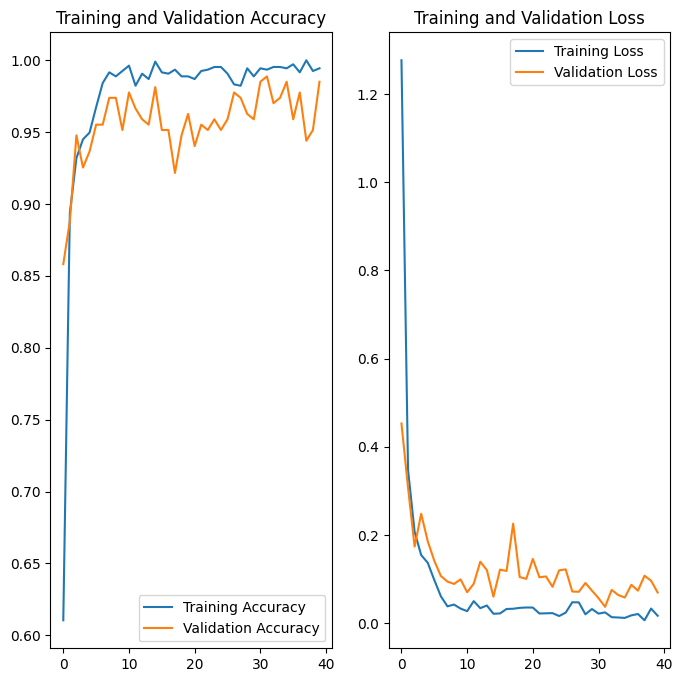

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))#epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

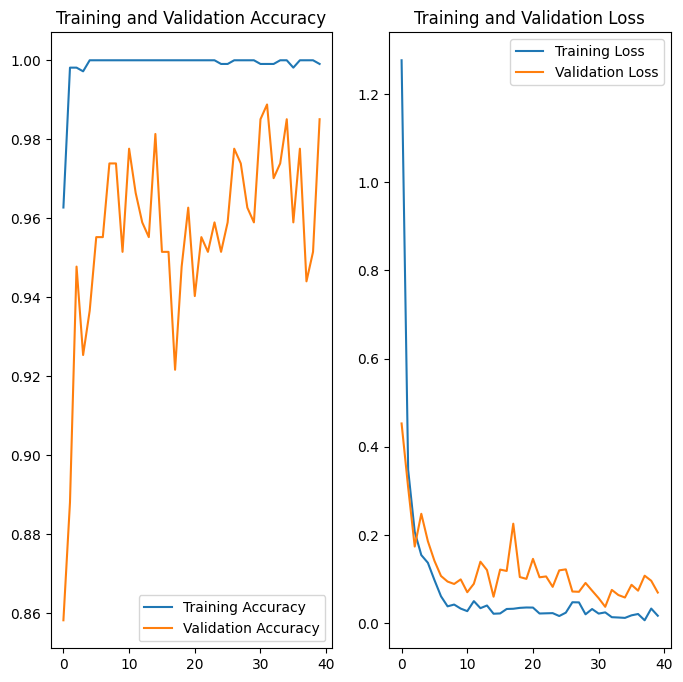

In [23]:
acc = history1.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))#epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#model.save('C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\efficientnet_model.keras')
model.save(path+'efficientnet_40_epochs_model_partial_data.keras')#path+'

In [27]:
test_ds1

TypeError: ignored

In [28]:
test_result = model.predict(test_ds1)

7/7 [==============================] - 14s 241ms/step


In [31]:
prediction = np.argmax(test_result, axis = 1)
prediction

array([ 9, 13,  3,  3, 14, 13, 12, 17,  3, 11, 17, 11, 13, 18,  3,  7,  0,
        3,  2,  8, 18,  0,  1,  0, 14,  4,  1, 13, 13,  5, 17,  4,  8, 12,
       12, 18, 11,  0, 13, 17,  2, 12, 18,  9,  7, 17, 10, 12,  0, 11,  7,
        2,  5,  2,  3, 11, 17, 15, 13,  0,  2, 17,  9,  8, 18, 12, 14, 11,
        4,  5, 14, 10,  6,  6, 18,  2,  0,  7,  8, 18, 16,  1, 12,  6, 15,
       13, 10,  7, 13,  0, 18,  7,  1,  7, 10, 14, 11, 10,  5,  9,  7, 10,
       17,  0,  1,  5,  7,  9,  5,  0, 14, 13, 17,  6,  5, 17, 17, 15,  3,
       16,  5,  7,  6,  7, 10,  7,  7, 18,  3, 15, 17, 13,  0, 15, 18,  2,
        2,  2,  6, 15, 18,  6,  6, 16, 18,  0,  9,  1, 11, 14,  3, 10, 17,
        5,  0, 17, 15, 10, 13,  3,  2, 14, 12,  1, 13, 12,  3, 15,  3, 18,
        1,  6, 10,  1, 15, 12, 14,  7, 17, 17,  7,  8,  9,  7, 11,  5,  0,
       16, 17, 16,  5,  9, 11, 12,  5,  6,  5, 18, 18])

In [32]:
model.evaluate(test_ds1)

7/7 [==============================] - 8s 106ms/step - loss: 0.8856 - accuracy: 0.7789


[0.885622501373291, 0.7788944840431213]

In [33]:
model_tmp.evaluate(test_ds1)

7/7 [==============================] - 8s 102ms/step - loss: 1.0648 - accuracy: 0.7136


[1.0648359060287476, 0.713567852973938]

In [ ]:
#path = os.getcwd()
prediction_folder = path + '\\prediction'
folder = prediction_folder + '\\*'
#os.scandir
#from glob import glob
files = glob(folder, recursive = True)
#folder

In [ ]:
files = glob(folder, recursive = True)
for image_path in files:
    image = tf.keras.utils.load_img(image_path)
    image = tf.image.resize(image, [img_height, img_width])
    input_arr = tf.keras.utils.img_to_array(image)
    predictions = model.predict(np.array([input_arr]))#(normalized_input_arr)
    print(image_path[image_path.rfind('\\')+1:], ' - ',np.argmax(predictions), '(',detail_names_list[np.argmax(predictions)],')')

1/1 [==============================] - 2s 2s/step
IMG_20230920_142557.jpg  -  9 ( СВП-120.00.060 )
1/1 [==============================] - 0s 152ms/step
IMG_20230920_142620.jpg  -  9 ( СВП-120.00.060 )
1/1 [==============================] - 0s 168ms/step
IMG_20230920_142632.jpg  -  9 ( СВП-120.00.060 )
1/1 [==============================] - 0s 154ms/step
IMG_20230920_142640.jpg  -  9 ( СВП-120.00.060 )
1/1 [==============================] - 0s 138ms/step
IMG_20230920_142656.jpg  -  9 ( СВП-120.00.060 )
